In [1]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd

import os
import os.path as osp
import sys
import time

import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision as tv
import torch.optim as optim

import torch.utils.data as data
import torchvision.datasets

import numpy as np
from PIL import Image
import argparse

from matplotlib import pyplot as plt
import pandas as pd
import cv2 
import pickle as pkl
import random
import tarfile
import collections
import math
import datetime
import pickle

from opts import *
import xml.etree.ElementTree as ET

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

In [4]:
def train(device, resume=None):
    
    #initialize config
    cfg = voc
    dataset = VOCDetection(root=dataset_root, image_sets=[('2012', 'train')],
                            transform=SSDAugmentation(cfg['min_dim'],
                             MEANS))
    ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
        
    if resume:
        print('Resuming training, loading previous training at ',resume)
        ssd_net.load_weights(resume) 
    else:
        vgg_weights = torch.load(basenet)
        print('Loading base network...')
        ssd_net.vgg.load_state_dict(vgg_weights)
        print('Initializing weights...')
        ssd_net.extras.apply(weights_init)
        ssd_net.loc.apply(weights_init)
        ssd_net.conf.apply(weights_init)
        
    net = ssd_net
    if device:
        net = torch.nn.DataParallel(ssd_net)
        torch.backends.cudnn.benchmark = True
        net = net.to(device)
        
    optimizer = optim.RMSprop(net.parameters(), lr=lr,weight_decay=weight_decay)
    criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                             False, torch.cuda.is_available())

    
    net.train()
    name = 'train'
    
    # loss counters
    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading the dataset...')

    epoch_size = len(dataset) // batch_size
    print('Training SSD on: ',name)

    step_index = 0


    train_data_loader = data.DataLoader(dataset, batch_size=32, num_workers=4, shuffle=True,\
                               collate_fn=detection_collate,pin_memory=True)
    
    print("Number of images in the training set = " + str(len(dataset)))
    print("Number of images in a mini-batch = "+str(batch_size))
    print("Number of mini-batches = " + str(len(train_data_loader)))
    
    
     # create batch iterator
    batch_iterator = iter(train_data_loader)
    print("STARTING - ITERATIONS")
    
    # Stats for pickle and plotting
    l_loss = []
    c_loss = []
    itr = []
    
    for iteration in range(0, 10000):
        
        if iteration != 0 and (iteration % epoch_size == 0):
            # reset epoch loss counters
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        if iteration in cfg['lr_steps']:
            step_index += 1
            lr_dec = lr * (gamma ** (step_index))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dec

            
        ## load train data
        try:
            images, targets = next(batch_iterator)
        except StopIteration:
            batch_iterator = iter(train_data_loader)
            images, targets = next(batch_iterator)


        
        if device:
            images = images.cuda()
            targets = [ann.cuda() for ann in targets]
        else:
            images = images
            targets = [ann for ann in targets]
        
        # forward
        t0 = time.time()
        out = net(images)

        # backprop
        optimizer.zero_grad()

        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c

        loss.backward()

        optimizer.step()

        t1 = time.time()
        loc_loss += loss_l.data.item()
        conf_loss += loss_c.data.item()

        l_loss.append(loss_l.data.item())
        c_loss.append(loss_c.data.item())
        itr.append(iteration)
        
        if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data.item()), end=' ')
            currentDT = datetime.datetime.now()
            print (currentDT.strftime("%H:%M:%S %p"))
            print("\n")

        
        if iteration != 0 and iteration % 10 == 0:
            print('Saving state, iter:', iteration)
            iter_name = math.ceil(iteration/100)*100
            torch.save(ssd_net.state_dict(), 'weights/ssd_VOC_RMSProp_' +repr(iter_name) + '.pth')
            with open('stats_RMSProp.pkl','wb') as f:
                pkl.dump([l_loss, c_loss, itr], f)
                

    torch.save(ssd_net.state_dict(),
               save_folder + data_set + '.pth') 

In [5]:
!cat opts.py

#Initialize pointers
basenet = 'weights/vgg16_reducedfc.pth'
data_set = 'VOC'
dataset_root = voc_root = '//datasets/ee285f-public/PascalVOC2012/'
save_folder = 'trained_weights/'
trained_model = 'ssd_pretrained.pth'
eval_save_folder = 'eval/'
devkit_path = 'devkit_path/'
output_dir = "out/"

#Run related metaparameters

batch_size = 32
resume = None

#Optimization metaparameters
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
    
confidence_threshold = 0.01
top_k = 5
cleanup = True

YEAR = '2012'
dataset_mean = (104, 117, 123)
set_type = 'train'


In [ ]:
train(device, resume)

Loading base network...
Initializing weights...
Loading the dataset...
Training SSD on:  train
Number of images in the training set = 5717
Number of images in a mini-batch = 32
Number of mini-batches = 179
STARTING - ITERATIONS


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 50.7943 sec.
iter 0 || Loss: 25.9056 || 08:41:26 AM


timer: 1.6040 sec.
iter 10 || Loss: 488.8744 || 08:42:54 AM


Saving state, iter: 10
timer: 3.0976 sec.
iter 20 || Loss: 17.8533 || 08:46:08 AM


Saving state, iter: 20
timer: 2.6946 sec.
iter 30 || Loss: 13.3618 || 08:48:30 AM


Saving state, iter: 30
timer: 2.4810 sec.
iter 40 || Loss: 12.4807 || 08:51:34 AM


Saving state, iter: 40
timer: 2.5022 sec.
iter 50 || Loss: 13.3958 || 08:54:00 AM


Saving state, iter: 50
timer: 3.3990 sec.
iter 60 || Loss: 11.4552 || 08:57:17 AM


Saving state, iter: 60
timer: 2.1050 sec.
iter 70 || Loss: 8.6826 || 08:59:36 AM


Saving state, iter: 70
timer: 2.2085 sec.
iter 80 || Loss: 8.8992 || 09:02:58 AM


Saving state, iter: 80
timer: 2.0925 sec.
iter 90 || Loss: 8.8541 || 09:05:21 AM


Saving state, iter: 90
timer: 1.8959 sec.
iter 100 || Loss: 7.7064 || 09:08:32 AM


Saving state, iter: 100
timer: 2.7000 sec.
iter 110 || Loss: 7.7342 || 09:10:55 AM


Saving state, iter: 110
timer: 2.0997 s

### Pickling saved loss values after 700 iterations for plotting

Text(0, 0.5, 'Loss')

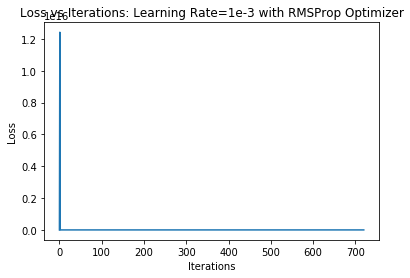

In [7]:
with open('optimization_experiments/pickles/stats_RMSProp.pkl','rb') as f:
    l_loss, c_loss, itr = pickle.load(f)

l_loss = np.asarray(l_loss)
c_loss = np.asarray(c_loss)
itr = np.asarray(itr)
plt.plot(itr,l_loss+c_loss)
plt.title('Loss vs Iterations: Learning Rate=1e-3 with RMSProp Optimizer')
plt.xlabel('Iterations')
plt.ylabel('Loss')